# DATA 542 Project
##### Yuzhou Wang: 98487499
##### Huan He: 74371576
##### Jingran Zhao: 44582641

## RQ 1: 
What types of issues (bugs, feature requests, theoretical questions, etc.) do developers most 
commonly present to ChatGPT? 

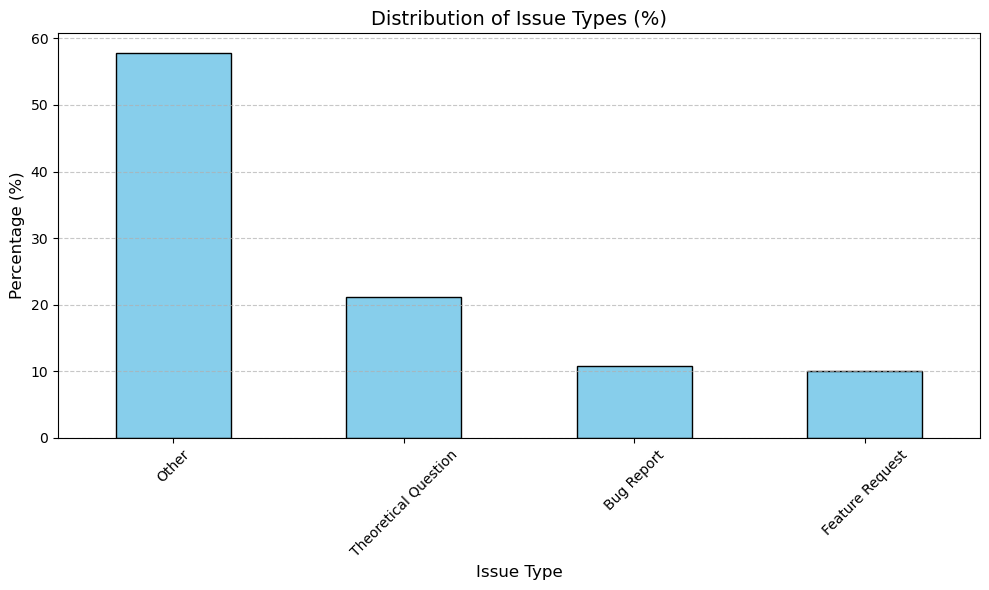

Issue types have been classified and saved to 'classified_conversations.csv'.


In [2]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import re

# Load the dataset
# Ensure the merged dataset (merged_conversations.csv) is in the same directory as the script.
data = pd.read_csv('merged_conversations.csv')

# Fill missing values in the 'Prompt' column and ensure it is in string format
# This avoids issues when processing textual data with missing entries.
data['Prompt'] = data['Prompt'].fillna('').astype(str)

# Define a function to classify issues based on keywords in the prompt
def classify_issue(prompt):
    """
    Classifies a developer's prompt into one of four categories:
    1. Bug Report: Indicates a technical issue or error.
    2. Feature Request: Suggests adding or improving a feature.
    3. Theoretical Question: Asks a question or seeks conceptual help.
    4. Other: Prompts that do not fit into the above categories.

    Parameters:
    prompt (str): The developer's input prompt to ChatGPT.

    Returns:
    str: The classified issue type.
    """
    # Convert the prompt to lowercase for case-insensitive keyword matching
    prompt = prompt.lower()
    
    # Match keywords to classify the issue type
    if any(keyword in prompt for keyword in ['bug', 'error', 'crash', 'fix', 'fail']):
        return 'Bug Report'
    elif any(keyword in prompt for keyword in ['feature', 'enhance', 'add', 'implement', 'improve']):
        return 'Feature Request'
    elif 'how to' in prompt or '?' in prompt:
        return 'Theoretical Question'
    else:
        return 'Other'

# Apply the classification function to the dataset
# This creates a new column 'IssueType' containing the issue categories.
data['IssueType'] = data['Prompt'].apply(classify_issue)

# Calculate the distribution of issue types
# Normalize=True calculates the percentages of each type instead of raw counts.
issue_counts = data['IssueType'].value_counts(normalize=True) * 100

# Plot the distribution of issue types
# The bar chart visualizes the proportion of each issue type in the dataset.
plt.figure(figsize=(10, 6))
issue_counts.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Issue Types (%)', fontsize=14)
plt.xlabel('Issue Type', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout for better appearance
plt.show()

# Save the results to a new CSV file
# This file will include the original dataset along with the 'IssueType' column.
data.to_csv('classified_conversations.csv', index=False, encoding='utf-8-sig')

# Print a confirmation message
print("Issue types have been classified and saved to 'classified_conversations.csv'.")


## RQ3: 
What is the typical structure of conversations between developers and ChatGPT? How many turns does it take on average to reach a conclusion? 

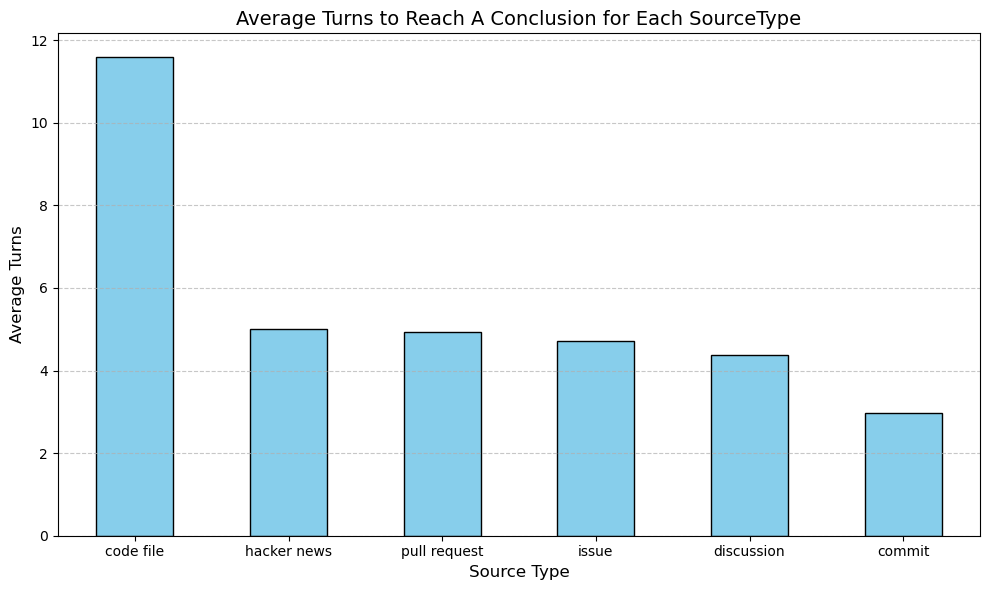

In [3]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import re

# Load the dataset
# Ensure the merged dataset (merged_conversations.csv) is in the same directory as the script.
data = pd.read_csv('merged_conversations.csv')


# Define a function to analyze the average turns for each source type
def analyze_average_turns(data):
    """
    Analyze the average number of turns to reach a conclusion for each SourceType.
    
    Parameters:
        data (pd.DataFrame): The input dataframe containing columns 'SourceType', 'SourceURL', and 'NumberOfPrompts'.
    
    Returns:
        pd.Series: A series containing the average turns grouped by 'SourceType', sorted in descending order.
    """
    # Remove duplicates based on specific columns
    data_unique = data.drop_duplicates(subset=['SourceType', 'SourceURL', 'NumberOfPrompts'])
    
    # Calculate the average number of prompts grouped by 'SourceType'
    average_turns = data_unique.groupby('SourceType')['NumberOfPrompts'].mean().sort_values(ascending=False)
    
    return average_turns

# Apply the classification function to the dataset
results = analyze_average_turns(data)

# Plot the distribution of average turns of each source type
plt.figure(figsize=(10, 6))
results.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Turns to Reach A Conclusion for Each SourceType', fontsize=14)
plt.xlabel('Source Type', fontsize=12)
plt.ylabel('Average Turns', fontsize=12)
_ = plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout for better appearance
plt.show()


## RQ:6 
What types of quality issues (for example, as identified by linters) are common in the SQL code 
generated by ChatGPT?

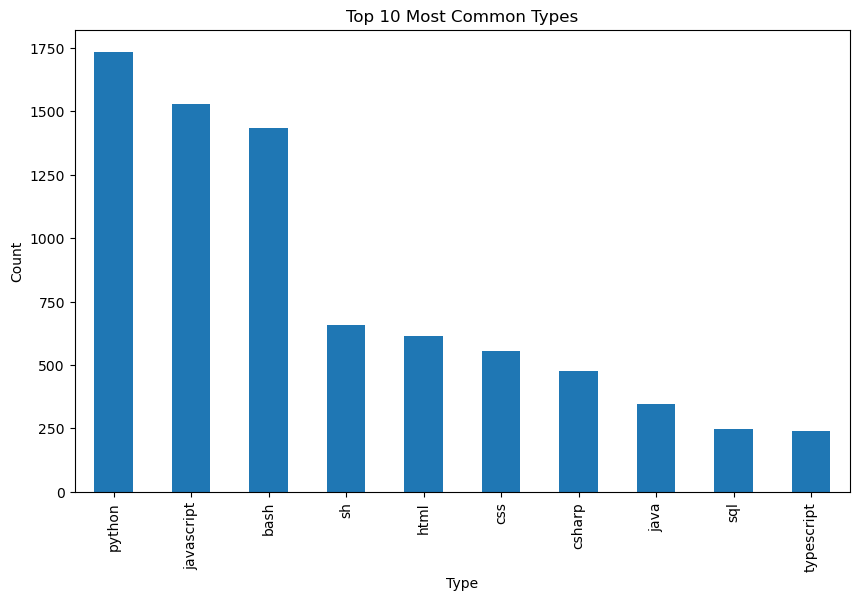

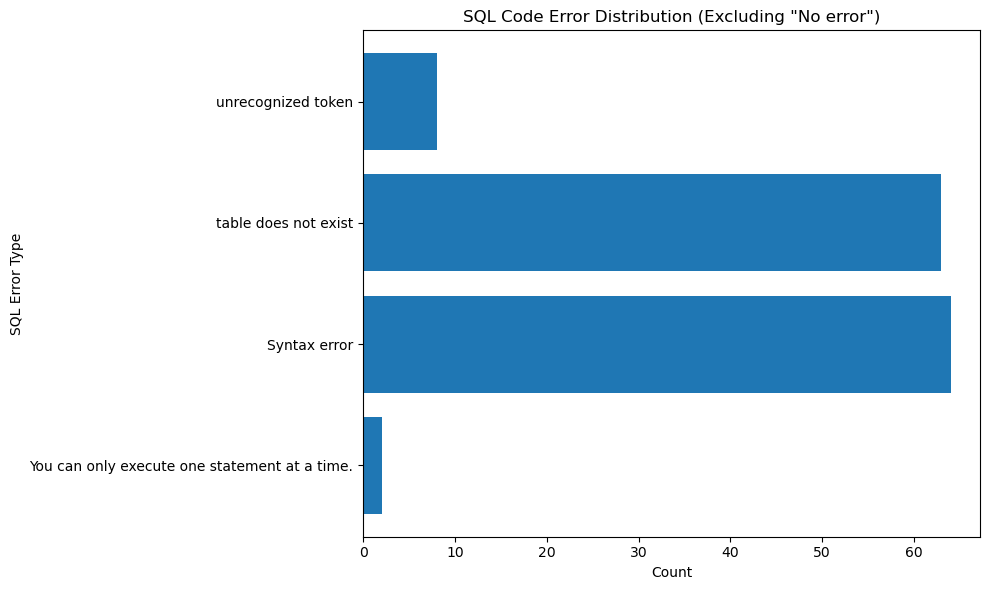

In [5]:
#data['ListOfCode'].value_counts()
import ast
def extract_types(list_of_code):
    if pd.isna(list_of_code) or list_of_code == '[]':
        return []
    return[item.get('Type') for item in ast.literal_eval(list_of_code) if 'Type' in item]

data['ExtractedTypes'] = data["ListOfCode"].apply(extract_types)
data['ExtractedTypes'].value_counts()
from collections import Counter
from itertools import chain
type_counts = Counter(chain.from_iterable(data["ExtractedTypes"]))
type_counts_series = pd.Series(type_counts)
ax=type_counts_series.sort_values(ascending=False)[:10].plot(kind='bar', figsize=(10,6))
ax.set_xlabel('Type')
ax.set_ylabel('Count')
ax.set_title('Top 10 Most Common Types')
# Function to extract types
def extract_types(list_of_code):
    """
    Extract the 'Type' fields from a list of code objects.

    Parameters:
    list_of_code (str): A string representation of a list of dictionaries, where each dictionary represents a code snippet and may contain a 'Type' key.

    Returns:
    list: A list of 'Type' values extracted from the input. If the input is NaN or an empty list ('[]'), an empty list is returned.
    """
    if pd.isna(list_of_code) or list_of_code == '[]':
        return []
    return [item.get('Type') for item in ast.literal_eval(list_of_code) if 'Type' in item]

# Extract types and filter for Python snippets
data['ExtractedTypes'] = data["ListOfCode"].apply(extract_types)
data['ExtractedContent'] = data["ListOfCode"].apply(lambda x: [
    item.get('Content') for item in ast.literal_eval(x) 
    if 'Type' in item and item['Type'] == 'sql'
])

# Flatten and find unique Python snippets
all_sql_contents = list(chain.from_iterable(data['ExtractedContent']))
unique_sql_contents = list(set(all_sql_contents))
import sqlite3

def simulate_sql_execution(sql_code):
    """
    Simulate the execution of an SQL statement using an in-memory SQLite database.

    Parameters:
    sql_code (str): A string containing the SQL statement to execute.

    Returns:
    str or None: Returns a specific error message if an error occurs during execution, such as:
        - "table does not exist": If the referenced table does not exist.
        - "Syntax error": If there is a syntax error in the SQL statement.
        - "unrecognized token": If an unrecognized token is found in the SQL.
        - Any other error message as a string.
        - None if the SQL executes without errors.
    """
    try:
        # Connect to an in-memory SQLite database
        conn = sqlite3.connect(':memory:')
        cursor = conn.cursor()
        # Execute SQL code (ensure it's safe to run, e.g., no injections)
        cursor.execute(sql_code)
        conn.commit()  # Commit if it's a DML statement
        conn.close()
        return None  # No error
    except sqlite3.OperationalError as e:
        # Check if the error message contains 'no such table'
        if "no such table" in str(e).lower():
            return "table does not exist"
        elif "syntax" in str(e).lower():
            return "Syntax error" 
        elif "unrecognized token":
            return "unrecognized token"
        else:
            return str(e)
    except Exception as e:
        return str(e)  # Return any other general errors
# Map each SQL code to its error (if any)
error_mapping = {}
for sql_code in unique_sql_contents:
    error_message = simulate_sql_execution(sql_code)
    if error_message:
        error_mapping[sql_code] = error_message
    else:
        error_mapping[sql_code] = 'No error'
        filtered_errors = {sql: error for sql, error in error_mapping.items() if error != 'No error'}

# Count the frequency of each error
error_counts = {}
for error in filtered_errors.values():
    error_counts[error] = error_counts.get(error, 0) + 1

# Plotting the errors (Horizontal bar plot)
plt.figure(figsize=(10, 6))

# Convert dict_keys to lists for the bar plot
plt.barh(list(error_counts.keys()), list(error_counts.values()))
plt.gca().invert_yaxis()  # Invert y-axis for better visual
plt.xlabel('Count')
plt.ylabel('SQL Error Type')
plt.title('SQL Code Error Distribution (Excluding "No error")')
plt.tight_layout()
plt.show()